In [1]:
import numpy as np
from scipy import ndimage
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
image_dim = 60
offset_count = 10
direction_count = 20000

# Generate synthetic image to be reconstructed

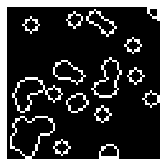

In [3]:
 
def generate_synthetic_image(img_dim):
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:img_dim, 0:img_dim]
    mask_outer = (x - img_dim / 2.) ** 2 + (y - img_dim / 2.) ** 2 < (img_dim / 2.) ** 2
    mask_outer = y;
    mask = np.zeros((img_dim, img_dim))
    points = img_dim * rs.rand(2, n_pts)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=img_dim / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))

data = generate_synthetic_image(image_dim)
plt.figure;plt.subplot(121);plt.axis('off')
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')


In [4]:
# Generate a set of coordinate matrices to be used for matrix rotation
def generate_coordinates(image_dim,offset):
    X, Y = np.mgrid[:image_dim, :image_dim].astype(np.float64)
    center = image_dim * offset
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y

# Generating reconstruction matrix A

In [5]:
def generate_A(img_dim, dirn_count, offset_count):
    # Dimensions of the design matrix A: number of rays(rotated lines) used * offset count X total of number of pixels in image
    A = np.zeros((dirn_count*offset_count,img_dim**2))
    onesmat = np.ones((img_dim, img_dim))
    angles = np.linspace(0, np.pi, dirn_count, endpoint=False) 
    offsets=np.linspace(0,1,offset_count)
    for j,offset in enumerate(offsets):
        X, Y = generate_coordinates(img_dim,offset)
        for i, angle in enumerate(angles):
            # Create a matrix rotated by angle, xor with a ones matrix to get matrix with all zeros except along one axis
            Xrot = np.round(np.cos(angle) * X - np.sin(angle) * Y)
            #### Replace Xrot matrix with a mask that will pick out only the zero values from the Xrot matrix.
            Xrot = 1*np.logical_xor(Xrot,onesmat)
            Arow = np.ravel(Xrot)
            # Insert Arow into the appropriate row of A
            A[j*(offset_count+2)+i,:] = Arow

    # Generate y from which we will reconstruct x
    # Here,the true image is vectorized as a result of which data_y is also vectorized
    data_y = A @ data.ravel()[:, np.newaxis]
    return data_y, A


# Run Ridge Regression and display images

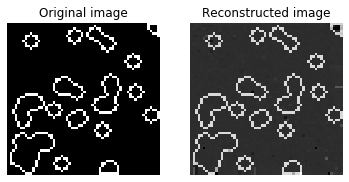

In [6]:
data_y, A_mat = generate_A(image_dim, direction_count, offset_count)

# Run ridge regression with lambda = 0.01
rgr_ridge = Ridge(alpha=0.01)
rgr_ridge.fit(A_mat, data_y.ravel()[:, np.newaxis])

# The reconstructed image will be vectorized as the true image was vectorized 
# This will need to be de-vectorised. Hence the reshaping
rec_l2 = rgr_ridge.coef_.reshape(image_dim, image_dim)

plt.figure; plt.subplot(121); plt.axis('off'); plt.title('Original image')
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')


plt.subplot(122); plt.title('Reconstructed image'); plt.axis('off')
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation='nearest')
